# ARMAX

In [56]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [57]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]
# Pandas configuration
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [58]:
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))
sj_train_train, sj_train_test, iq_train_train, iq_train_test = data_subsets_splitted_joined

## Adding lags

In [59]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 0, which is the original feature (without shift).
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

In [60]:
env_cols = sj_train_train.columns.to_list()
unwanted = ['week_start_date',
            'city',
            'year',
            'weekofyear',
            'month',
            'total_cases',
            'total_cases_o_seas',
            'total_cases_wo_seas'
           ]
env_cols = [e for e in env_cols if e not in unwanted]

In [61]:
sj_train_train_lags = get_lagged_dataframe(sj_train_train, env_cols, 4)
sj_train_train = sj_train_train.join(sj_train_train_lags)
sj_train_train = sj_train_train[sj_train_train.columns.drop(list(sj_train_train.filter(regex='lag0')))]

In [62]:
sj_train_test_lags = get_lagged_dataframe(sj_train_test, env_cols, 4)

In [63]:
sj_train_test = sj_train_test.join(sj_train_test_lags)
sj_train_test = sj_train_test[sj_train_test.columns.drop(list(sj_train_test.filter(regex='lag0')))]

## Wisorizing

In [64]:
def winsorizer(df, colname, clip_upper, time_ratio=0.5):
    '''
    Inputs:
    df: dataframe
    colname: name of the variable to be winsorised
    clip_upper: where to clip the values in proportion to the global maximum,
    e.g. 0.8 => clip the values above 80% of the global maximum of the variable
    ratio: what portion of the series should be winsorised, 
    e.g. 0.3 => the first third of the series is modified.
    Output: the dataframe with one modified variable
    '''
    early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
    late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
    clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
    df[colname] = pd.concat([clipped_var, late[colname]])
    return df

In [65]:
sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

In [66]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!
def get_smooth_seasonality_df(df, colnames):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly_median = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .median(axis=1)
        )
        jan = pd.Series(weekly_median[1])
        jan.index = [len(weekly_median)+1]

        dec = pd.Series(weekly_median[len(weekly_median)])
        dec.index = [weekly_median.index[0]-1]

        weekly_median = weekly_median.append(jan)
        weekly_median = weekly_median.append(dec)

        smooth_seasonality = (
            weekly_median
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df.index = df.index.rename('weekofyear')
    return df

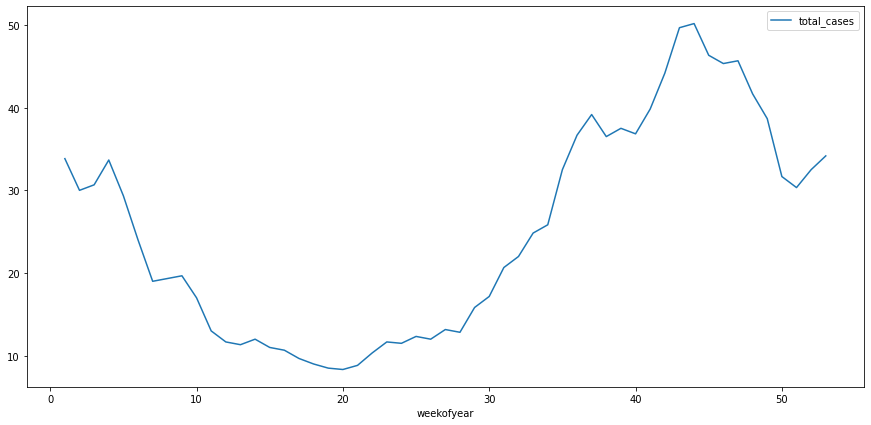

In [67]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases')
sj_train_train_seas.plot();

## Seasonality as a baseline model

In [68]:
def seasonality_predict(df, seas):
    '''
    Ins:
    df with total_cases weekofyear (only for dimensions)
    seas seasonality(of the train data, data leakage!) = the model 
    Outs:
    series with predictions based on the model (seasonality) and the test data 
    (here only used for the dimensions)
    '''
    eval_df = (
        df
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [69]:
# seasonality_predict(sj_train_test, sj_train_train_seas)

In [70]:
# function for evaluation of models
def model_classification(actual, predicted): 
    """
    Prints out RSME, MAE and explained variance score
    """
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [71]:
def seasonality_baseline_eval(df, seas):
    eval_df = (
        df
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 26.96
--------------------
MAE: 18.26
Explained variance: 0.117
--------------------


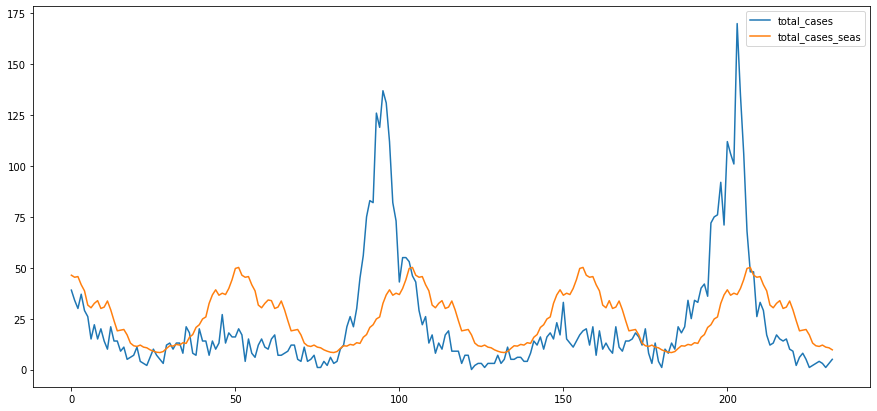

In [72]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

In [73]:
def substract_seas(df, cols, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            get_smooth_seasonality_df(df, cols),
            how='left', 
            on='weekofyear',
            suffixes=('','_o_seas')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_o_seas' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )        
    
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_o_seas' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [74]:
def transfer_seasonality(df, seas):
    df_w_seas = (
        df
#         .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_o_seas')
              )
        .assign(total_cases_wo_seas = lambda df: df.total_cases - df.total_cases_o_seas)
    )
    return df_w_seas

In [75]:
sj_train_train = substract_seas(sj_train_train, 'total_cases')
sj_train_test = transfer_seasonality(sj_train_test, sj_train_train_seas)
sj_train_test

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,...,reanalysis_min_air_temp_c_lag1,reanalysis_min_air_temp_c_lag2,reanalysis_min_air_temp_c_lag3,reanalysis_min_air_temp_c_lag4,population_lag1,population_lag2,population_lag3,population_lag4,total_cases_o_seas,total_cases_wo_seas
0,2003-11-05,sj,2003,45,0.079225,0.163500,0.137717,0.124800,35.90,78.080000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.333333,-7.333333
1,2003-11-12,sj,2003,46,0.069250,0.055375,0.065486,0.074886,92.10,81.825714,...,24.35,NaN,NaN,NaN,2403420.0,NaN,NaN,NaN,45.333333,-11.333333
2,2003-11-19,sj,2003,47,-0.217950,0.015000,0.128143,0.135014,181.74,87.575714,...,25.15,24.35,NaN,NaN,2403420.0,2403420.0,NaN,NaN,45.666667,-15.666667
3,2003-11-26,sj,2003,48,-0.070150,-0.037775,0.236943,0.208457,38.70,83.410000,...,24.55,25.15,24.35,NaN,2403420.0,2403420.0,2403420.0,NaN,41.666667,-4.666667
4,2003-12-03,sj,2003,49,-0.003050,0.053400,0.127567,0.117486,10.26,77.308571,...,24.05,24.55,25.15,24.35,2403420.0,2403420.0,2403420.0,2403420.0,38.666667,-9.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2008-03-25,sj,2008,13,0.077850,-0.039900,0.310471,0.296243,7.55,74.247143,...,21.75,22.95,22.35,23.15,2369802.0,2369802.0,2369802.0,2369802.0,11.333333,-7.333333
229,2008-04-01,sj,2008,14,-0.038000,-0.016833,0.119371,0.066386,3.67,74.600000,...,21.25,21.75,22.95,22.35,2369802.0,2369802.0,2369802.0,2369802.0,12.000000,-9.000000
230,2008-04-08,sj,2008,15,-0.155200,-0.052750,0.137757,0.141214,35.00,75.027143,...,23.35,21.25,21.75,22.95,2369802.0,2369802.0,2369802.0,2369802.0,11.000000,-10.000000
231,2008-04-15,sj,2008,16,0.001800,-0.031558,0.203900,0.209843,4.82,72.285714,...,22.65,23.35,21.25,21.75,2369802.0,2369802.0,2369802.0,2369802.0,10.666667,-7.666667


In [77]:
env_cols = sj_train_train.columns.to_list()
unwanted = ['week_start_date',
            'city',
            'year',
            'weekofyear',
            'month',
            'total_cases',
            'total_cases_o_seas',
            'total_cases_wo_seas'
           ]
env_cols = [e for e in env_cols if e not in unwanted]

sj_train_train = substract_seas(sj_train_train, env_cols, drop=True)
sj_train_test = substract_seas(sj_train_test, env_cols, drop=True)

In [84]:
env_cols = sj_train_train.columns.to_list()
unwanted = ['week_start_date',
            'city',
            'year',
            'weekofyear',
            'month',
            'total_cases',
            'total_cases_o_seas',
            'total_cases_wo_seas'
           ]
env_cols = [e for e in env_cols if e not in unwanted]

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [86]:
my_order = (2, 0, 4) 
sarimax_model = SARIMAX(sj_train_train.dropna().total_cases_wo_seas, 
                        order=my_order,
                        exog=sj_train_train.dropna()[env_cols])

/home/mario/.pyenv/versions/3.8.5/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mario/.pyenv/versions/3.8.5/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [87]:
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     total_cases_wo_seas   No. Observations:                  699
Model:                SARIMAX(2, 0, 4)   Log Likelihood               -3055.156
Date:                 Sun, 01 Aug 2021   AIC                           6324.311
Time:                         20:07:11   BIC                           6811.124
Sample:                              0   HQIC                          6512.506
                                 - 699                                         
Covariance Type:                   opg                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
ndvi_ne_wo_seas                                       92.8521     13.502      6.877      0.000      66.388     119.316
ndv

In [157]:
pred = sarimax_model_fit.forecast(len(sj_train_test.dropna().total_cases_wo_seas), exog=sj_train_test.dropna()[env_cols])

/home/mario/.pyenv/versions/3.8.5/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [158]:
pred = pd.Series(pred)
pred.index = sj_train_test.dropna().index

In [159]:
x = transfer_seasonality(sj_train_test, sj_train_train_seas)
x = x.dropna()

In [160]:
pred = pred + x.total_cases_o_seas

In [161]:
pred

4       9.289114
5      21.133210
6      22.673878
7      29.900697
8      16.093478
         ...    
228   -21.987522
229   -22.468050
230   -28.305692
231    17.981546
232    27.613693
Length: 229, dtype: float64

In [162]:
pred = pred.shift(-4)

In [163]:
pred

4      16.093478
5      17.990399
6       0.653574
7      -4.063903
8      10.118277
         ...    
228    27.613693
229          NaN
230          NaN
231          NaN
232          NaN
Length: 229, dtype: float64

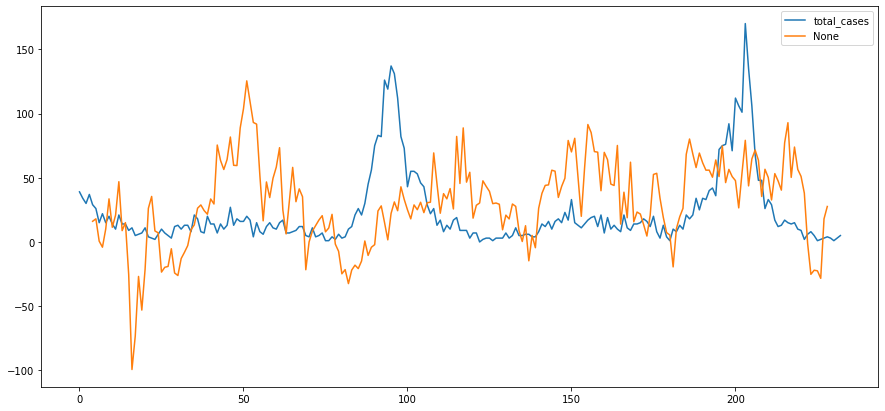

In [164]:
sj_train_test.total_cases.plot(legend=True)
pred.plot(legend=True);

In [165]:
pred = pred.dropna().reset_index(drop=True)
pred = pred.clip(lower=0)

In [166]:
test = sj_train_test.dropna().total_cases.iloc[:225].reset_index(drop=True)

In [167]:
model_classification(pred, test)

--------------------
RMSE: 38.54
--------------------
MAE: 29.06
Explained variance: -0.84
--------------------
